In [2]:
import pandas as pd
import pandas.tseries.offsets as offsets

import numpy as np
import datetime
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_absolute_error as mae 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import time
import pickle

import utils

In [3]:
def data_loader():
    train = pd.read_csv("JR/train.csv")
    test = pd.read_csv("JR/test.csv")
    info= pd.read_csv("JR/info.csv")

    network = pd.read_csv("JR/network.csv")

    # print(train.head())
    # exit()
    # train2 = utils.reduce_mem_usage(train)
    # train2.to_csv("JR/train2.csv")
    # test2 = utils.reduce_mem_usage(test)
    # test2.to_csv("JR/test2.csv")
    # exit()
    return train, test, info, network

def preprocess(train, test, info, network):
    train_num = len(train)
    df = pd.concat([train, test])
    
    df["stop_and_direction"] = df["stopStation"] + df["directionCode"].astype(str)
    le = LabelEncoder()
    df["stop_and_direction"] = le.fit_transform(df["stop_and_direction"])
    
    
    le = LabelEncoder()
    df["stopStation"] = le.fit_transform(df.stopStation)
    #network["station1"] = le.transform(network.station1)
    #network["station2"] = le.transform(network.station2)
    
    le = LabelEncoder()
    df["trainNo"] = le.fit_transform(df.trainNo)
    
    le = LabelEncoder()
    df["lineName"] = le.fit_transform(df.lineName)
    info["lineName"] = le.transform(info.lineName)
    
    le = LabelEncoder()
    info["cse"] = le.fit_transform(info.cse)
    
    le = LabelEncoder()
    df["stop_and_direction"] = le.fit_transform(df.stop_and_direction)
    
    #print(df.head())
    #make daytime
    df["date_and_time"] = df.date.astype(str) + ":"+df.planArrival.astype(str)
    df["date_and_time"] = pd.to_datetime(df["date_and_time"], format='%Y%m%d:%H:%M')
    
    info["date_and_time"] = info.date.astype(str) + ":"+info.time.astype(str)
    info["date_and_time"] = pd.to_datetime(info["date_and_time"], format='%Y%m%d:%H:%M')
    df["cse"] = 23
    #print(df.head())
    #print(info.head())
    #return 0,0,0
    for i in range(len(info)):
        intime = info.date_and_time[i]
        intime = intime + datetime.timedelta(hours=2)
        df.loc[
            (info.date_and_time[i] <= df.date_and_time) &
            (intime > df.date_and_time) & 
            (df.date == info.date[i]) &
            #(info.cse[i] != 0) &
            (df.lineName == info.lineName[i]),"cse"] = info.cse[i]
        #print(sum(info.date_and_time[i] <= df.date_and_time))
        #print(sum(df.date == info.date[i]))
        #print(sum(df.lineName == info.lineName[i]))
        #print(sum( (info.date_and_time[i] <= df.date_and_time) &
        #    (df.date == info.date[i]) &
        #    (df.lineName == info.lineName[i])))
        #print(info.cse[i])
        #break
        #print(sum([(info.date_and_time[i] > df.date_and_time) &(df.date == info.date[i]) &(df.lineName == info.lineName[i])]))
    return df[:train_num], df[train_num:], info

train, test, info, network = data_loader()
train, test, info = preprocess(train, test, info, network)
print("finish")

finish


In [19]:
#kf = StratifiedKFold(n_splits=5, random_state = 14)
#kf = TimeSeriesSplit(n_splits = 5)
kf = KFold(n_splits = 5, random_state = 14)
score = 0
counter = 1
models = []
target_col = "delayTime"
feature_cols = [
            #"date",
            #"MM", "DD",
    "cse",
    'lineName', 'directionCode', 'trainNo', 'stopStation',
     'stop_and_direction'
    ]

for train_index, valid_index in kf.split(train):
#for train_index, valid_index in kf.split(train):

        
            train_X,valid_X = train.loc[train_index,:].copy()  , train.loc[valid_index,:].copy()
            tr, te = utils.make_feature(train_X, valid_X)

            t4 = time.time()
            
            X_train, X_valid = tr[feature_cols] , te[feature_cols]
            y_train, y_valid = tr[target_col], te[target_col]
            X_train = pd.concat([X_train, test[~(test.delayTime.isna())][feature_cols]])
            y_train = pd.concat([y_train, test[~(test.delayTime.isna())][target_col]])

            print(X_train.shape)
            
            clf = lgb.LGBMRegressor()
            # clf = lgb.LGBMClassifier()
            # clf = lgb.LGBMClassifier(**params)

            clf.fit(X_train,y_train)
            
            preds = clf.predict(X_valid[feature_cols])

            #evaluation
            acc_score = mae(y_valid,preds)
            print("fold score is :",acc_score)
            score += acc_score
            counter += 1
            t5 = time.time()
            print("learning:",round(t5-t4,1))

            models.append(clf)

print("average : ",round(score/5,5))
train,test = utils.make_feature(train, test)
y_pred = [model.predict(test[feature_cols].values) for model in models[2:]]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred, axis=0)

if False:

     clf = lgb.LGBMRegressor().fit(train[feature_cols],train[target_col])
     y_pred = clf.predict(test[feature_cols])


    #make submit
    #よう調整
y_pred = y_pred[test.target == 1]
pd.DataFrame({"id":test[test.target == 1].id, target_col: y_pred }).to_csv("submission.csv", index=False, header = False)
    # pd.DataFrame({"id": range(len(pred_test)), target_col: pred_test }).to_csv("submission.csv", index=False)

importance = pd.DataFrame(clf.booster_.feature_importance(importance_type='gain'), index=feature_cols, columns = ["f"])
print(importance.sort_values("f", ascending = False).head(15))
print(importance.sort_values("f", ascending = False).tail(15))


mkf: 2.9
(1607858, 6)
fold score is : 1.7019614317485756
learning: 4.8
mkf: 3.1
(1607858, 6)
fold score is : 1.7768995167996184
learning: 4.3
mkf: 2.8
(1607858, 6)
fold score is : 1.8120496819087426
learning: 4.4
mkf: 3.0
(1607858, 6)
fold score is : 2.110946512046867
learning: 4.8
mkf: 3.1
(1607858, 6)
fold score is : 1.495269109018827
learning: 5.0
average :  1.77943
mkf: 5.4
                               f
cse                 3.432813e+07
trainNo             6.321446e+06
lineName            3.675305e+06
directionCode       1.762814e+06
stopStation         3.915888e+05
stop_and_direction  1.119334e+05
                               f
cse                 3.432813e+07
trainNo             6.321446e+06
lineName            3.675305e+06
directionCode       1.762814e+06
stopStation         3.915888e+05
stop_and_direction  1.119334e+05


In [20]:
train.tail(10)

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,stop_and_direction,date_and_time,cse,MM,DD
1488875,1488875,20201022,3,2,2969,88,18:32,0.0,NaN,176,2020-10-22 18:32:00,23,18,32
1488876,1488876,20201022,3,2,2969,12,18:34,0.0,NaN,25,2020-10-22 18:34:00,23,18,34
1488877,1488877,20201022,3,2,2969,16,18:38,0.0,NaN,32,2020-10-22 18:38:00,23,18,38
1488878,1488878,20201022,3,2,2969,64,18:42,0.0,NaN,128,2020-10-22 18:42:00,23,18,42
1488879,1488879,20201022,3,2,2969,42,18:44,0.0,NaN,84,2020-10-22 18:44:00,23,18,44
1488880,1488880,20201022,3,2,2969,3,18:47,0.0,NaN,7,2020-10-22 18:47:00,23,18,47
1488881,1488881,20201022,3,2,2969,2,18:51,1.0,NaN,5,2020-10-22 18:51:00,23,18,51
1488882,1488882,20201022,3,2,2969,95,18:53,0.0,NaN,190,2020-10-22 18:53:00,23,18,53
1488883,1488883,20201022,3,2,2969,101,18:59,0.0,NaN,202,2020-10-22 18:59:00,23,18,59
1488884,1488884,20201022,3,2,2969,77,19:01,1.0,NaN,154,2020-10-22 19:01:00,23,19,1


In [21]:
#network = pd.read_csv("JR/network.csv")
network.head()

,network_id,station1,station2
0,1,vpGT,Femc
1,2,Femc,dJlm
2,3,dJlm,jebQ
3,4,jebQ,PsTo
4,5,PsTo,mxQg


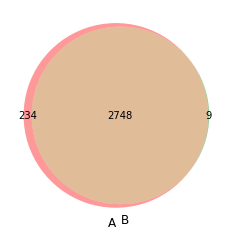

In [22]:
from matplotlib_venn import venn2
venn2([set(train.trainNo.unique()), set(test.trainNo.unique())])


In [23]:
info.head()

,info_id,date,time,lineName,directionCode1,directionCode2,all,station_from,station_to,cse,date_and_time
0,0,20191220,8:04,0,1,1,1,-,-,20,2019-12-20 08:04:00
1,1,20191220,8:09,0,1,1,1,-,-,20,2019-12-20 08:09:00
2,2,20191220,8:14,0,1,1,1,-,-,20,2019-12-20 08:14:00
3,3,20191220,8:16,0,1,1,1,-,-,20,2019-12-20 08:16:00
4,4,20191220,8:25,0,1,1,1,-,-,20,2019-12-20 08:25:00


In [24]:
test.tail(10)

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,stop_and_direction,date_and_time,cse,MM,DD
1259219,2748104,20201021,3,2,2969,88,18:32,0.0,0.0,176,2020-10-21 18:32:00,23,18,32
1259220,2748105,20201021,3,2,2969,12,18:34,0.0,0.0,25,2020-10-21 18:34:00,23,18,34
1259221,2748106,20201021,3,2,2969,16,18:38,0.0,0.0,32,2020-10-21 18:38:00,23,18,38
1259222,2748107,20201021,3,2,2969,64,18:42,0.0,0.0,128,2020-10-21 18:42:00,23,18,42
1259223,2748108,20201021,3,2,2969,42,18:44,0.0,0.0,84,2020-10-21 18:44:00,23,18,44
1259224,2748109,20201021,3,2,2969,3,18:47,0.0,0.0,7,2020-10-21 18:47:00,23,18,47
1259225,2748110,20201021,3,2,2969,2,18:51,0.0,0.0,5,2020-10-21 18:51:00,23,18,51
1259226,2748111,20201021,3,2,2969,95,18:53,0.0,0.0,190,2020-10-21 18:53:00,23,18,53
1259227,2748112,20201021,3,2,2969,101,18:59,0.0,0.0,202,2020-10-21 18:59:00,23,18,59
1259228,2748113,20201021,3,2,2969,77,19:01,NaN,1.0,154,2020-10-21 19:01:00,23,19,1


In [25]:
train.columns

Index(['id', 'date', 'lineName', 'directionCode', 'trainNo', 'stopStation',
       'planArrival', 'delayTime', 'target', 'stop_and_direction',
       'date_and_time', 'cse', 'MM', 'DD'],
      dtype='object')

In [26]:
len(info)

1041

In [27]:
info.cse.value_counts()

4     193
14    129
20     90
15     80
12     69
18     67
17     57
22     51
0      47
13     40
9      38
16     33
11     31
8      27
21     20
5      18
1      16
10     11
2       8
7       7
6       5
19      3
3       1
Name: cse, dtype: int64

In [28]:
network

,network_id,station1,station2
0,1,vpGT,Femc
1,2,Femc,dJlm
2,3,dJlm,jebQ
3,4,jebQ,PsTo
4,5,PsTo,mxQg
...,...,...,...
108,109,UMoa,BCRD
109,110,BCRD,AVjc
110,111,AVjc,uYlv
111,112,uYlv,wwYD


In [29]:
train.date_and_time[0].hour 

6

In [30]:
train.cse.value_counts()

23    1404518
4       10549
20       9688
0        9330
14       7693
9        5871
12       5633
17       5158
18       5088
15       5078
16       4821
21       3721
10       2902
13       2321
1        2188
2        1762
6        1452
11        939
19        173
Name: cse, dtype: int64

In [31]:
train.head()

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,stop_and_direction,date_and_time,cse,MM,DD
0,0,20191204,0,1,11,37,06:11,0.0,NaN,73,2019-12-04 06:11:00,23,6,11
1,1,20191204,0,1,11,53,06:13,0.0,NaN,105,2019-12-04 06:13:00,23,6,13
2,2,20191204,0,1,11,22,06:16,0.0,NaN,43,2019-12-04 06:16:00,23,6,16
3,3,20191204,0,1,11,44,06:18,0.0,NaN,87,2019-12-04 06:18:00,23,6,18
4,4,20191204,0,1,11,72,06:20,0.0,NaN,143,2019-12-04 06:20:00,23,6,20


In [32]:
y_pred

array([0.95495141, 0.95600332, 0.95891029, ..., 1.08734821, 0.98525192,
       1.26965907])

In [34]:
train.groupby(["cse","lineName"])["delayTime"].mean()

cse  lineName
0    0            2.350352
     2            2.051508
     3            4.473128
1    0            4.914077
2    2            6.408059
4    0            5.958499
     2           10.469512
     3           12.869072
6    3            1.799587
9    0            1.688760
     3            3.426667
10   0            6.635400
     2            7.507757
11   3            1.862620
12   0            9.390843
     3            6.064470
13   2            5.232435
     3           28.140187
14   0            0.682545
     2            9.875595
     3            0.193895
15   0            9.745766
     3            3.096045
16   0            5.754642
     2           13.350165
     3            5.844744
17   0           18.230047
     2            6.507227
18   0            3.581766
     3           12.465647
19   0            1.393064
20   0            8.907933
     2            9.641231
     3            8.493021
21   2            4.986604
     3           13.333897
23   0        